In [ ]:
import os 
os.chdir("/Users/ryanalvin/Downloads/Final_Project")

from generate_lumpy_background import *
import matplotlib.pyplot as plt
import numpy as np, numpy.linalg as la
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
import pandas as pd



from observer_cho import create_gabor_channels
from observer_hotelling import hotelling_observer
from observer_cho import create_laguerre_gauss_channels, cho_analysis

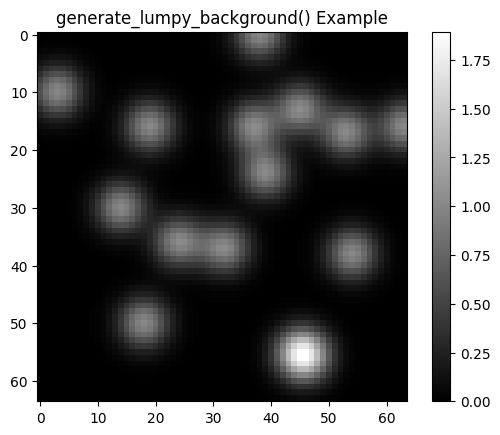

In [3]:
samp_bg = generate_lumpy_background()

plt.imshow(samp_bg,cmap='grey')
plt.title("generate_lumpy_background() Example")
plt.colorbar()
plt.show()

In [4]:
def add_gaussian_blob(img, size=3,ampl=2):
    h, w = img.shape
    x_cent = h // 2
    y_cent = w // 2

    y_coords,x_coords = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')

    dist_sq = (x_coords - x_cent)**2 + (y_coords - y_cent)**2
    blob = ampl * np.exp(-dist_sq / (2 * size**2))

    return img + blob

def add_noise(img, noise_stdev):
    noise = np.random.normal(0, noise_stdev, img.shape)
    return img + noise


def generate_dataset(N_samples, N_bar=15,a=1,w_b=3, signal_present=True,noise_stdev=1):
    data = []
    labels = []

    for i in range(N_samples):
        bg = generate_lumpy_background(N_bar=N_bar,a=a,w_b=w_b)
        
        if signal_present:
            bg = add_gaussian_blob(bg)
            labels.append(1)
        else:
            labels.append(0)
            
        noisy_img = add_noise(bg, noise_stdev)
        data.append(noisy_img.flatten())

    return np.array(data), np.array(labels)




N_train, N_test = 10000, 1000
# generating train data
X_train_none, y_train_none = generate_dataset(N_train, signal_present=False)
X_train_signal, y_train_signal = generate_dataset(N_train, signal_present=True)

X_train = np.vstack([X_train_none, X_train_signal])
y_train = np.concatenate([y_train_none, y_train_signal])
X_train, y_train = shuffle(X_train, y_train, random_state=11)


# generating test data
X_test_none, y_test_none = generate_dataset(N_test, signal_present=False)
X_test_signal, y_test_signal = generate_dataset(N_test, signal_present=True)

X_test = np.vstack([X_test_none, X_test_signal])
y_test = np.concatenate([y_test_none, y_test_signal])
X_test, y_test = shuffle(X_test, y_test, random_state=11)


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((20000, 4096), (20000,), (2000, 4096), (2000,))

In [ ]:


# Inputs should be lists of 2D images
scores = hotelling_observer(
    train_present=[img.reshape(64, 64) for img in X_train[y_train == 1]],
    train_absent=[img.reshape(64, 64) for img in X_train[y_train == 0]],
    test_images=[img.reshape(64, 64) for img in X_test]
)

from sklearn.metrics import roc_auc_score

auc_ho = roc_auc_score(y_test, scores)
print(f"HO AUC: {auc_ho:.3f}")


HO AUC: 0.997


In [ ]:


lg_channels = create_laguerre_gauss_channels(dim=(64, 64), sigmas=[3, 6, 9])

# Same train/test image format as HO
scores_lg = cho_analysis(
    train_present=[img.reshape(64, 64) for img in X_train[y_train == 1]],
    train_absent=[img.reshape(64, 64) for img in X_train[y_train == 0]],
    test_images=[img.reshape(64, 64) for img in X_test],
    channels=lg_channels
)

auc_lg = roc_auc_score(y_test, scores_lg)
print(f"CHO (LG) AUC: {auc_lg:.3f}")


CHO (LG) AUC: 0.998


In [ ]:


gabor_channels = create_gabor_channels(dim=(64, 64), freqs=[0.1, 0.2], thetas=[0, np.pi/4, np.pi/2])

scores_gabor = cho_analysis(
    train_present=[img.reshape(64, 64) for img in X_train[y_train == 1]],
    train_absent=[img.reshape(64, 64) for img in X_train[y_train == 0]],
    test_images=[img.reshape(64, 64) for img in X_test],
    channels=gabor_channels
)

auc_gabor = roc_auc_score(y_test, scores_gabor)
print(f"CHO (Gabor) AUC: {auc_gabor:.3f}")


CHO (Gabor) AUC: 0.803


In [9]:




# Create results directory
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

def plot_auc_vs_param(param_name, values, ho_aucs, cho_lg_aucs, cho_gabor_aucs):
    plt.figure(figsize=(8, 6))
    plt.plot(values, ho_aucs, label='HO', marker='o')
    plt.plot(values, cho_lg_aucs, label='CHO (Laguerre-Gauss)', marker='o')
    plt.plot(values, cho_gabor_aucs, label='CHO (Gabor)', marker='o')
    plt.xlabel(param_name)
    plt.ylabel("AUC")
    plt.title(f"AUC vs. {param_name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    save_path = os.path.join(RESULTS_DIR, f"AUC_vs_{param_name}.png")
    plt.savefig(save_path)
    print(f"Plot saved to: {save_path}")
    plt.close()

def evaluate_auc_vs(param_name, values, fixed_args):
    N_train, N_test = 10000, 1000
    ho_aucs, cho_lg_aucs, cho_gabor_aucs = [], [], []

    for val in values:
        print(f"\n Running: {param_name} = {val}")
        kwargs = fixed_args.copy()
        kwargs[param_name] = val

        X_train_none, y_train_none = generate_dataset(N_train, signal_present=False, **kwargs)
        X_train_signal, y_train_signal = generate_dataset(N_train, signal_present=True, **kwargs)
        X_train = np.vstack([X_train_none, X_train_signal])
        y_train = np.concatenate([y_train_none, y_train_signal])
        X_train, y_train = shuffle(X_train, y_train, random_state=11)

        X_test_none, y_test_none = generate_dataset(N_test, signal_present=False, **kwargs)
        X_test_signal, y_test_signal = generate_dataset(N_test, signal_present=True, **kwargs)
        X_test = np.vstack([X_test_none, X_test_signal])
        y_test = np.concatenate([y_test_none, y_test_signal])
        X_test, y_test = shuffle(X_test, y_test, random_state=11)

        train_present = [img.reshape(64, 64) for img in X_train[y_train == 1]]
        train_absent = [img.reshape(64, 64) for img in X_train[y_train == 0]]
        test_imgs = [img.reshape(64, 64) for img in X_test]

        # HO
        ho_scores = hotelling_observer(train_present, train_absent, test_imgs)
        auc_ho = roc_auc_score(y_test, ho_scores)

        # CHO Laguerre-Gauss
        lg_channels = create_laguerre_gauss_channels()
        cho_lg_scores = cho_analysis(train_present, train_absent, test_imgs, lg_channels)
        auc_lg = roc_auc_score(y_test, cho_lg_scores)

        # CHO Gabor
        gabor_channels = create_gabor_channels()
        cho_gabor_scores = cho_analysis(train_present, train_absent, test_imgs, gabor_channels)
        auc_gabor = roc_auc_score(y_test, cho_gabor_scores)

        # Store
        ho_aucs.append(auc_ho)
        cho_lg_aucs.append(auc_lg)
        cho_gabor_aucs.append(auc_gabor)

        print(f"  HO AUC: {auc_ho:.4f}")
        print(f"  CHO (Laguerre-Gauss) AUC: {auc_lg:.4f}")
        print(f"  CHO (Gabor) AUC: {auc_gabor:.4f}")

    # Plot and save
    plot_auc_vs_param(param_name, values, ho_aucs, cho_lg_aucs, cho_gabor_aucs)

    # Save and print CSV
    df = pd.DataFrame({
        param_name: values,
        "HO_AUC": ho_aucs,
        "CHO_LG_AUC": cho_lg_aucs,
        "CHO_Gabor_AUC": cho_gabor_aucs
    })
    csv_path = os.path.join(RESULTS_DIR, f"AUC_vs_{param_name}.csv")
    df.to_csv(csv_path, index=False)
    print(f"\n AUC results saved to: {csv_path}")
    print("\n AUC Results Summary:")
    print(df.to_string(index=False))

    return ho_aucs, cho_lg_aucs, cho_gabor_aucs

# 1. AUC vs Number of Lumps
evaluate_auc_vs(
    param_name="N_bar",
    values=[15, 100],
    fixed_args={"a": 3, "w_b": 3, "noise_stdev": 1}
)

# 2. AUC vs Lump Size
evaluate_auc_vs(
    param_name="w_b",
    values=[3, 6],
    fixed_args={"N_bar": 15, "a": 3, "noise_stdev": 1}
)

# 3. AUC vs Amplitude
evaluate_auc_vs(
    param_name="a",
    values=[3, 6],
    fixed_args={"N_bar": 15, "w_b": 3, "noise_stdev": 1}
)

# 4. AUC vs Noise Level
evaluate_auc_vs(
    param_name="noise_stdev",
    values=[1, 2, 3],
    fixed_args={"N_bar": 15, "w_b": 3, "a": 3}
)



 Running: N_bar = 15
  HO AUC: 0.9102
  CHO (Laguerre-Gauss) AUC: 0.9098
  CHO (Gabor) AUC: 0.6077

 Running: N_bar = 100
  HO AUC: 0.6954
  CHO (Laguerre-Gauss) AUC: 0.7053
  CHO (Gabor) AUC: 0.5583
Plot saved to: results/AUC_vs_N_bar.png

 AUC results saved to: results/AUC_vs_N_bar.csv

 AUC Results Summary:
 N_bar   HO_AUC  CHO_LG_AUC  CHO_Gabor_AUC
    15 0.910193    0.909768       0.607715
   100 0.695439    0.705344       0.558254

 Running: w_b = 3
  HO AUC: 0.9267
  CHO (Laguerre-Gauss) AUC: 0.9153
  CHO (Gabor) AUC: 0.6148

 Running: w_b = 6
  HO AUC: 0.9959
  CHO (Laguerre-Gauss) AUC: 0.9242
  CHO (Gabor) AUC: 0.5327
Plot saved to: results/AUC_vs_w_b.png

 AUC results saved to: results/AUC_vs_w_b.csv

 AUC Results Summary:
 w_b   HO_AUC  CHO_LG_AUC  CHO_Gabor_AUC
   3 0.926704    0.915288       0.614772
   6 0.995896    0.924180       0.532665

 Running: a = 3
  HO AUC: 0.9199
  CHO (Laguerre-Gauss) AUC: 0.9131
  CHO (Gabor) AUC: 0.6423

 Running: a = 6
  HO AUC: 0.7733
  CH

([0.907697, 0.8689440000000002, 0.8389039999999999],
 [0.90053, 0.898577, 0.8897390000000001],
 [0.61188, 0.59507, 0.612375])